In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from build_data import load_data

In [3]:
df = load_data(start_year=1850, end_year=2020)

Time Taken: 0.06596400000125868


In [4]:
df.head()

,year,month,Actual Temperature,City,Country,Latitude,Longitude,Actual Temperature_Air_Global,Actual Temperature_Water_Global,monthly_average_co2,population,year_average_VEI,year_events_amount
0,1850,1,-0.288,6_Tokyo,Japan,36.17,139.23,11.474,12.214,NaN,NaN,2.0,1.0
1,1850,2,0.783,6_Tokyo,Japan,36.17,139.23,12.227,12.993,NaN,NaN,2.0,1.0
2,1850,3,5.673,6_Tokyo,Japan,36.17,139.23,12.706,13.444,NaN,NaN,2.0,1.0
3,1850,4,9.840,6_Tokyo,Japan,36.17,139.23,13.396,14.119,NaN,NaN,2.0,1.0
4,1850,5,15.825,6_Tokyo,Japan,36.17,139.23,14.324,14.887,NaN,NaN,2.0,1.0


In [5]:
city_lat_long_df = df.groupby("City").agg({"Latitude":"first", "Longitude":"first"}).reset_index(drop=False)

### Feature Engineering

In [6]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['temp_lag_' + str(lag)] = dataframe.groupby(["Latitude", "Longitude"])['Actual Temperature_Air_Global'].transform(
            lambda x: x.shift(lag))
    return dataframe

In [7]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['temp_roll_mean_' + str(window)] = dataframe.groupby(["Latitude", "Longitude"])['Actual Temperature_Air_Global'].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=0,).mean())
    return dataframe

In [8]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['temp_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["Latitude", "Longitude"])['Actual Temperature_Air_Global'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [9]:
df_sub = df[df['year']>=1960][["year","month","Actual Temperature_Air_Global","Latitude","Longitude","monthly_average_co2",
             "population","year_average_VEI","year_events_amount"]].reset_index(drop=True)

In [10]:
df_sub_ = lag_features(df_sub, range(1,13))

In [11]:
df_sub_ = roll_mean_features(df_sub_, range(1,13))

In [12]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
df_sub_ = ewm_features(df_sub_, alphas, range(1,13))

In [13]:
df_sub_

,year,month,Actual Temperature_Air_Global,Latitude,Longitude,monthly_average_co2,population,year_average_VEI,year_events_amount,temp_lag_1,...,temp_ewm_alpha_05_lag_3,temp_ewm_alpha_05_lag_4,temp_ewm_alpha_05_lag_5,temp_ewm_alpha_05_lag_6,temp_ewm_alpha_05_lag_7,temp_ewm_alpha_05_lag_8,temp_ewm_alpha_05_lag_9,temp_ewm_alpha_05_lag_10,temp_ewm_alpha_05_lag_11,temp_ewm_alpha_05_lag_12
0,1960,1,12.219,36.17,139.23,316.43,3.031517e+09,3.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1960,2,12.544,36.17,139.23,316.98,3.031517e+09,3.0,1.0,12.219,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1960,3,12.722,36.17,139.23,317.58,3.031517e+09,3.0,1.0,12.544,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1960,4,13.838,36.17,139.23,319.03,3.031517e+09,3.0,1.0,12.722,...,12.219000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1960,5,14.893,36.17,139.23,320.03,3.031517e+09,3.0,1.0,13.838,...,12.435667,12.219000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,2020,8,16.744,49.03,2.45,412.75,7.821272e+09,4.0,1.0,16.885,...,15.300227,14.608454,14.008908,13.781815,13.894631,14.356262,15.056523,15.864046,16.365092,16.591185
14636,2020,9,16.197,49.03,2.45,411.50,7.821272e+09,4.0,1.0,16.744,...,15.942113,15.300227,14.608454,14.008908,13.781815,13.894631,14.356262,15.056523,15.864046,16.365092
14637,2020,10,15.183,49.03,2.45,411.48,7.821272e+09,4.0,1.0,16.197,...,16.413557,15.942113,15.300227,14.608454,14.008908,13.781815,13.894631,14.356262,15.056523,15.864046
14638,2020,11,14.323,49.03,2.45,413.10,7.821272e+09,4.0,1.0,15.183,...,16.578778,16.413557,15.942113,15.300227,14.608454,14.008908,13.781815,13.894631,14.356262,15.056523


In [14]:
df_sub_.dropna(inplace=True)

### Modelling

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import lightgbm as lgb

In [16]:
train = df_sub_.loc[(df_sub_["year"] < 2015), :]

val = df_sub_.loc[(df_sub_["year"] >= 2015), :]

cols = [col for col in train.columns if col not in ["year","Actual Temperature_Air_Global"]]

Y_train = train['Actual Temperature_Air_Global']
X_train = train[cols]

Y_val = val['Actual Temperature_Air_Global']
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape


((12000,), (12000, 91), (1200,), (1200, 91))

In [17]:
Y_val

660      13.098
661      13.338
662      13.974
663      14.844
664      15.815
          ...  
14635    16.744
14636    16.197
14637    15.183
14638    14.323
14639    13.360
Name: Actual Temperature_Air_Global, Length: 1200, dtype: float64

In [18]:
params = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.1,
    'boosting_type': 'dart'
}

model = lgb.LGBMRegressor(first_metric_only = True, **params)

pipe = make_pipeline(StandardScaler(), model)

In [19]:
pipe.fit(X_train, Y_train) 
  
# predicting values 
y_pred = pipe.predict(X_val) 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21807
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 91
[LightGBM] [Info] Start training from score 14.398045
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

In [20]:
type(y_pred)

numpy.ndarray

In [21]:
Y_val

660      13.098
661      13.338
662      13.974
663      14.844
664      15.815
          ...  
14635    16.744
14636    16.197
14637    15.183
14638    14.323
14639    13.360
Name: Actual Temperature_Air_Global, Length: 1200, dtype: float64

In [105]:
from sklearn.metrics import root_mean_squared_error
accuracy_score = root_mean_squared_error(y_pred,Y_val)

In [132]:
accuracy_score

np.float64(0.3255500157377395)

In [116]:
pipe.steps[1][1].feature_importances_

array([ 136,    0,    0, 1318,  740,  421,  237, 1673,  452,  422,  173,
        178, 2846,  373,  288,  110,  401,  236, 3084,    0,  502,  236,
        471,  173,  157,  809,   53,   85, 1532,  365,   73,  360,   30,
         88,  184,  125,   95,   93,   59,   64,   80,   92, 1857,  229,
         51,   44,    7,   45,   79,   65,   30,    8,   80,   58,  822,
        205,   48,   41,    5,   83,  214,   14,   89,  102,   21,   52,
        288,  212,   62,   29,   42,  206,  156,   11,   40,   89,   29,
        188,  253,  482,  271,   61,  116,  913,   68,   48,   97,  193,
        107, 2480,  375], dtype=int32)

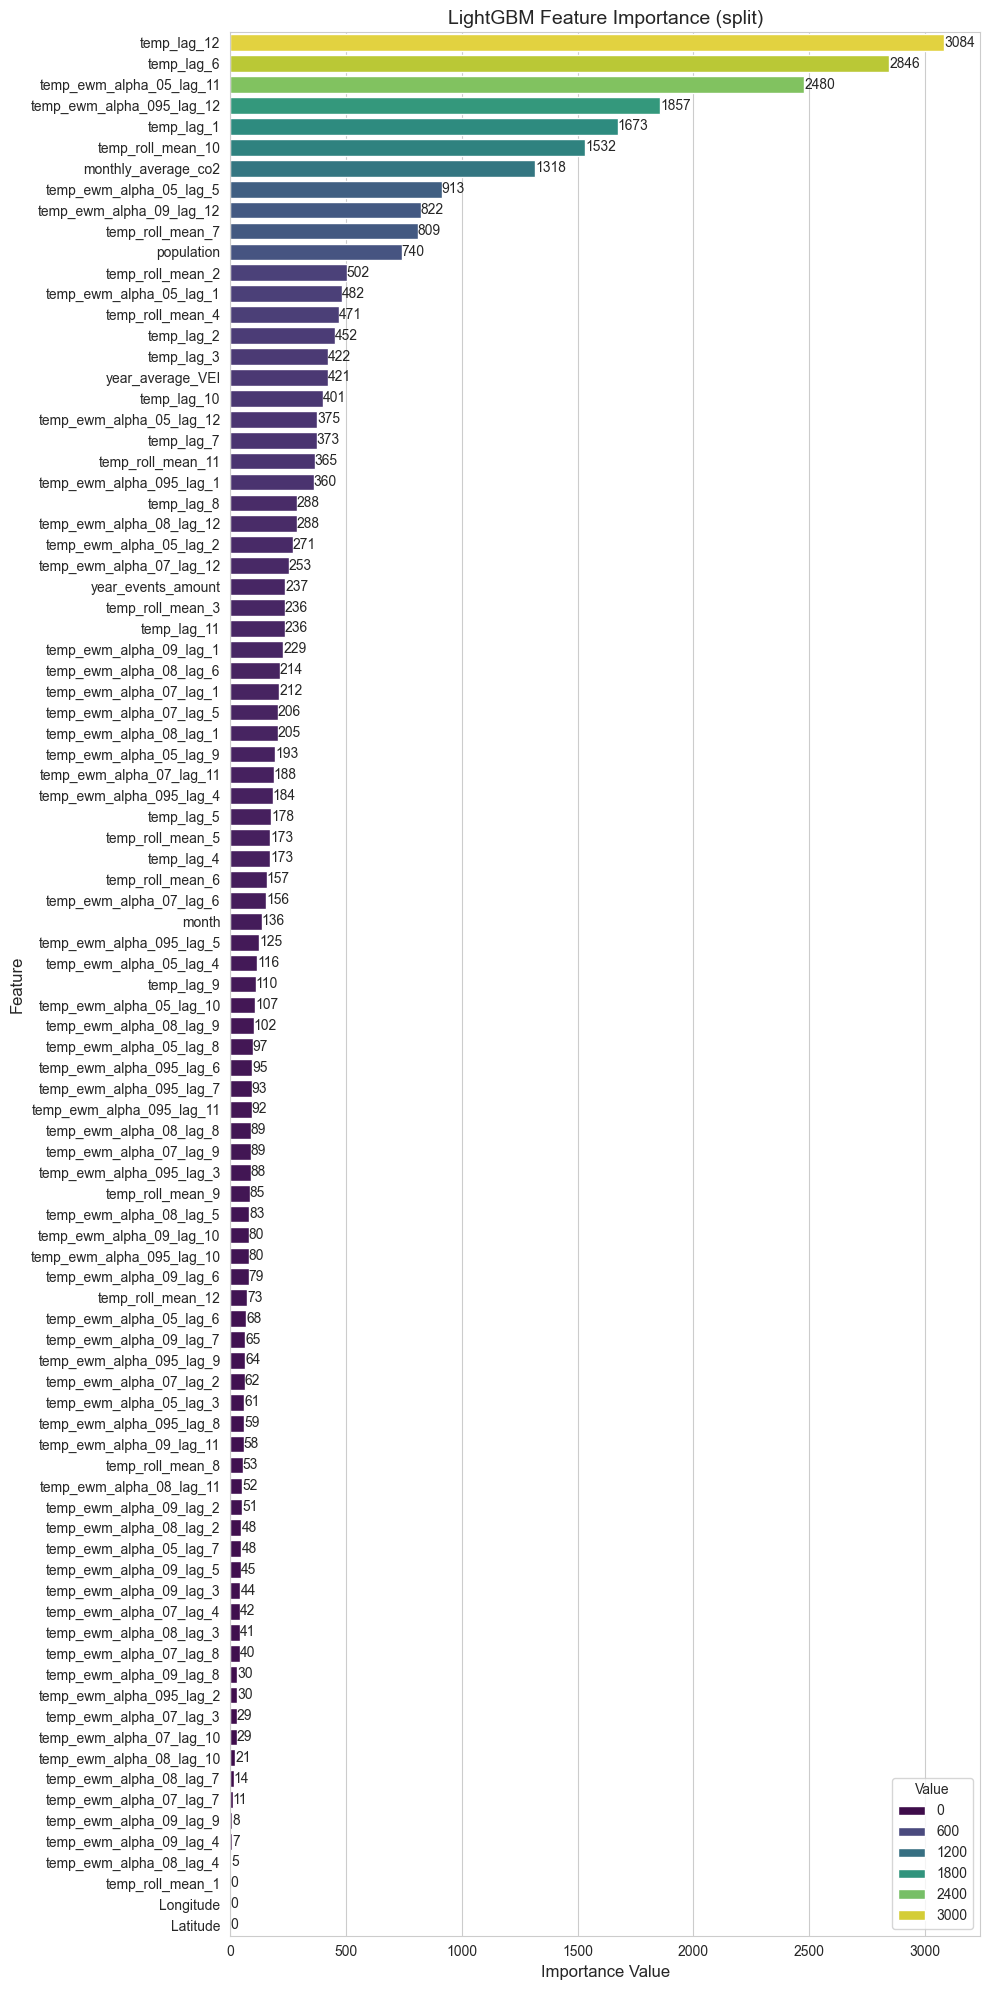

In [141]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Example feature_importance DataFrame
feature_imp = pd.DataFrame(
    sorted(zip(pipe.steps[1][1].feature_importances_, X_train.columns), reverse=True),
    columns=["Value", "Feature"]
)

# Normalize values for colormap
norm = plt.Normalize(feature_imp["Value"].min(), feature_imp["Value"].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)

# Create the plot
plt.figure(figsize=(10, 20))
sns.barplot(
    x="Value",
    y="Feature",
    hue="Value",
    data=feature_imp,
    palette="viridis"
)

# Annotating the values on the bars
for index, value in enumerate(feature_imp.sort_values(by="Value", ascending=False)["Value"]):
    plt.text(value + 0.01, index, f"{value}", va="center", ha="left", fontsize=10)

# Add color bar separately
# cbar = plt.colorbar(sm, orientation="vertical", pad=0.02)
# cbar.set_label("Feature Importance Value", fontsize=12)

plt.title('LightGBM Feature Importance (split)', fontsize=14)
plt.xlabel("Importance Value", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
# plt.show()
plt.savefig("../forecasting_results/forecasting_lgbm.png", bbox_inches='tight')

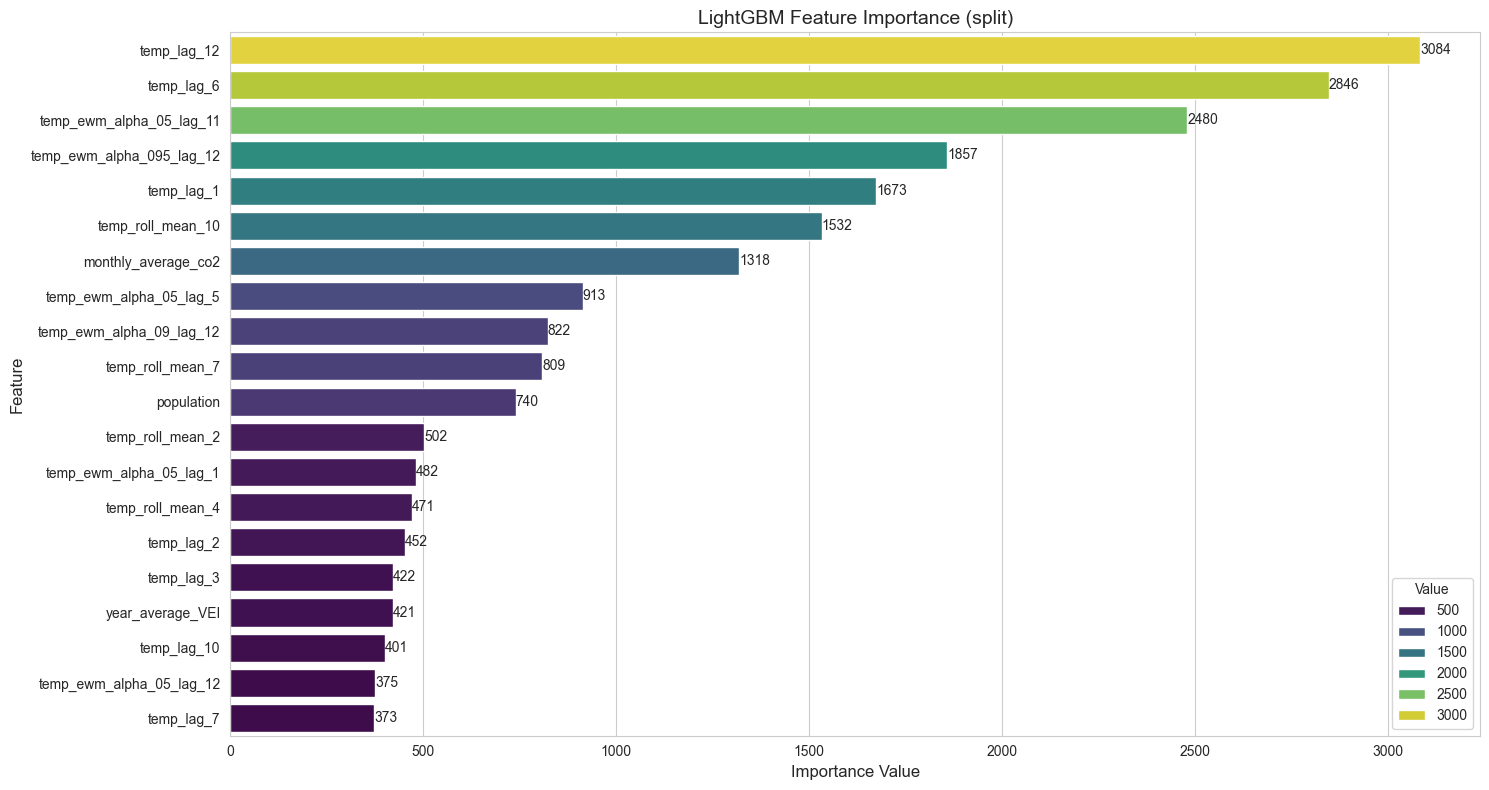

In [149]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Example feature_importance DataFrame
feature_imp = pd.DataFrame(
    sorted(zip(pipe.steps[1][1].feature_importances_, X_train.columns), reverse=True),
    columns=["Value", "Feature"]
)

feature_imp = feature_imp.iloc[:20]
# Normalize values for colormap
norm = plt.Normalize(feature_imp["Value"].min(), feature_imp["Value"].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)

# Create the plot
plt.figure(figsize=(15, 8))
sns.barplot(
    x="Value",
    y="Feature",
    hue="Value",
    data=feature_imp,
    palette="viridis"
)

# Annotating the values on the bars
for index, value in enumerate(feature_imp.sort_values(by="Value", ascending=False)["Value"]):
    plt.text(value + 0.01, index, f"{value}", va="center", ha="left", fontsize=10)

# Add color bar separately
# cbar = plt.colorbar(sm, orientation="vertical", pad=0.02)
# cbar.set_label("Feature Importance Value", fontsize=12)

plt.title('LightGBM Feature Importance (split)', fontsize=14)
plt.xlabel("Importance Value", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
# plt.show()
plt.savefig("../forecasting_results/forecasting_lgbm.png", bbox_inches='tight')

In [144]:
feature_imp.iloc[:20]

,Value,Feature
0,3084,temp_lag_12
1,2846,temp_lag_6
2,2480,temp_ewm_alpha_05_lag_11
3,1857,temp_ewm_alpha_095_lag_12
4,1673,temp_lag_1
5,1532,temp_roll_mean_10
6,1318,monthly_average_co2
7,913,temp_ewm_alpha_05_lag_5
8,822,temp_ewm_alpha_09_lag_12
9,809,temp_roll_mean_7


In [136]:
Y_train

12       12.285
13       12.610
14       13.099
15       14.133
16       15.122
          ...  
14563    16.680
14564    16.100
14565    15.110
14566    13.870
14567    13.311
Name: Actual Temperature_Air_Global, Length: 12000, dtype: float64

In [227]:
len(np.array(Y_val)), len(y_pred)

(1200, 1200)

In [231]:
yy = pd.DataFrame(zip(np.array(Y_val), y_pred), columns=['True','Predicted'])

In [232]:
yy

,True,Predicted
0,13.098,13.051033
1,13.338,12.856003
2,13.974,13.701316
3,14.844,14.768690
4,15.815,15.785941
...,...,...
1195,16.744,16.510914
1196,16.197,16.204882
1197,15.183,15.173227
1198,14.323,13.912592


In [233]:
yy.shape

(1200, 2)

In [234]:
X_val.shape

(1200, 91)

In [235]:
combined = pd.concat([X_val.reset_index(drop=True),yy], axis=1)

In [236]:
combined.isnull().sum()

month                       0
Latitude                    0
Longitude                   0
monthly_average_co2         0
population                  0
                           ..
temp_ewm_alpha_05_lag_10    0
temp_ewm_alpha_05_lag_11    0
temp_ewm_alpha_05_lag_12    0
True                        0
Predicted                   0
Length: 93, dtype: int64

In [237]:
combined

,month,Latitude,Longitude,monthly_average_co2,population,year_average_VEI,year_events_amount,temp_lag_1,temp_lag_2,temp_lag_3,...,temp_ewm_alpha_05_lag_5,temp_ewm_alpha_05_lag_6,temp_ewm_alpha_05_lag_7,temp_ewm_alpha_05_lag_8,temp_ewm_alpha_05_lag_9,temp_ewm_alpha_05_lag_10,temp_ewm_alpha_05_lag_11,temp_ewm_alpha_05_lag_12,True,Predicted
0,1,36.17,139.23,400.18,7.404251e+09,2.0,1.0,13.311,13.870,15.110,...,16.395188,16.110377,15.684754,15.024507,14.199015,13.559030,13.276059,13.524118,13.098,13.051033
1,2,36.17,139.23,400.55,7.404251e+09,2.0,1.0,13.098,13.311,13.870,...,16.247594,16.395188,16.110377,15.684754,15.024507,14.199015,13.559030,13.276059,13.338,12.856003
2,3,36.17,139.23,401.74,7.404251e+09,2.0,1.0,13.338,13.098,13.311,...,15.678797,16.247594,16.395188,16.110377,15.684754,15.024507,14.199015,13.559030,13.974,13.701316
3,4,36.17,139.23,403.35,7.404251e+09,2.0,1.0,13.974,13.338,13.098,...,14.774399,15.678797,16.247594,16.395188,16.110377,15.684754,15.024507,14.199015,14.844,14.768690
4,5,36.17,139.23,404.15,7.404251e+09,2.0,1.0,14.844,13.974,13.338,...,14.042699,14.774399,15.678797,16.247594,16.395188,16.110377,15.684754,15.024507,15.815,15.785941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,8,49.03,2.45,412.75,7.821272e+09,4.0,1.0,16.885,16.584,15.992,...,14.008908,13.781815,13.894631,14.356262,15.056523,15.864046,16.365092,16.591185,16.744,16.510914
1196,9,49.03,2.45,411.50,7.821272e+09,4.0,1.0,16.744,16.885,16.584,...,14.608454,14.008908,13.781815,13.894631,14.356262,15.056523,15.864046,16.365092,16.197,16.204882
1197,10,49.03,2.45,411.48,7.821272e+09,4.0,1.0,16.197,16.744,16.885,...,15.300227,14.608454,14.008908,13.781815,13.894631,14.356262,15.056523,15.864046,15.183,15.173227
1198,11,49.03,2.45,413.10,7.821272e+09,4.0,1.0,15.183,16.197,16.744,...,15.942113,15.300227,14.608454,14.008908,13.781815,13.894631,14.356262,15.056523,14.323,13.912592


In [189]:
city_lat_long_df

,City,Latitude,Longitude
0,10_Pretoria,-24.92,28.37
1,11_Marrakesh,31.35,-7.54
2,12_Anchorage,61.88,-151.13
3,13_SanDiego,32.95,-117.77
4,14_NewYork,40.99,-74.56
5,15_Paris,49.03,2.45
6,16_Rome,42.59,13.09
7,17_Barcelona,40.99,2.13
8,18_Helsinki,60.27,25.95
9,19_Sydney,-34.56,151.78


In [202]:
row[1].Longitude

90.46

In [203]:
ombined[(combined['Latitude'] == lat) & (combined['Longitude'] == long)]

,month,Latitude,Longitude,monthly_average_co2,population,year_average_VEI,year_events_amount,temp_lag_1,temp_lag_2,temp_lag_3,...,temp_ewm_alpha_05_lag_5,temp_ewm_alpha_05_lag_6,temp_ewm_alpha_05_lag_7,temp_ewm_alpha_05_lag_8,temp_ewm_alpha_05_lag_9,temp_ewm_alpha_05_lag_10,temp_ewm_alpha_05_lag_11,temp_ewm_alpha_05_lag_12,True,Predicted
0,1,36.17,139.23,400.18,7.404251e+09,2.0,1.0,13.311,13.870,15.110,...,16.395188,16.110377,15.684754,15.024507,14.199015,13.559030,13.276059,13.524118,13.098,13.051033
1,2,36.17,139.23,400.55,7.404251e+09,2.0,1.0,13.098,13.311,13.870,...,16.247594,16.395188,16.110377,15.684754,15.024507,14.199015,13.559030,13.276059,13.338,12.856003
2,3,36.17,139.23,401.74,7.404251e+09,2.0,1.0,13.338,13.098,13.311,...,15.678797,16.247594,16.395188,16.110377,15.684754,15.024507,14.199015,13.559030,13.974,13.701316
3,4,36.17,139.23,403.35,7.404251e+09,2.0,1.0,13.974,13.338,13.098,...,14.774399,15.678797,16.247594,16.395188,16.110377,15.684754,15.024507,14.199015,14.844,14.768690
4,5,36.17,139.23,404.15,7.404251e+09,2.0,1.0,14.844,13.974,13.338,...,14.042699,14.774399,15.678797,16.247594,16.395188,16.110377,15.684754,15.024507,15.815,15.785941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,8,49.03,2.45,412.75,7.821272e+09,4.0,1.0,16.885,16.584,15.992,...,14.008908,13.781815,13.894631,14.356262,15.056523,15.864046,16.365092,16.591185,16.744,16.510914
1196,9,49.03,2.45,411.50,7.821272e+09,4.0,1.0,16.744,16.885,16.584,...,14.608454,14.008908,13.781815,13.894631,14.356262,15.056523,15.864046,16.365092,16.197,16.204882
1197,10,49.03,2.45,411.48,7.821272e+09,4.0,1.0,16.197,16.744,16.885,...,15.300227,14.608454,14.008908,13.781815,13.894631,14.356262,15.056523,15.864046,15.183,15.173227
1198,11,49.03,2.45,413.10,7.821272e+09,4.0,1.0,15.183,16.197,16.744,...,15.942113,15.300227,14.608454,14.008908,13.781815,13.894631,14.356262,15.056523,14.323,13.912592


0     13.098
1     13.338
2     13.974
3     14.844
4     15.815
5     16.494
6     16.690
7     16.662
8     16.084
9     15.347
10    14.255
11    13.686
12    13.326
13    13.619
14    14.277
15    15.022
16    15.934
17    16.394
18    16.766
19    16.691
20    15.974
21    15.179
22    14.093
23    13.491
24    13.109
25    13.365
26    13.988
27    14.967
28    15.798
29    16.471
30    16.764
31    16.622
32    16.001
33    15.265
34    14.057
35    13.472
36    13.187
37    13.433
38    14.278
39    15.089
40    15.877
41    16.549
42    16.911
43    16.792
44    16.139
45    15.363
46    14.249
47    13.656
48    13.433
49    13.669
50    14.236
51    15.208
52    15.992
53    16.584
54    16.885
55    16.744
56    16.197
57    15.183
58    14.323
59    13.360
Name: True, dtype: float64 0     13.051033
1     12.856003
2     13.701316
3     14.768690
4     15.785941
5     16.274814
6     16.487420
7     16.469765
8     15.850917
9     14.977287
10    13.842584
11    13.077959
1

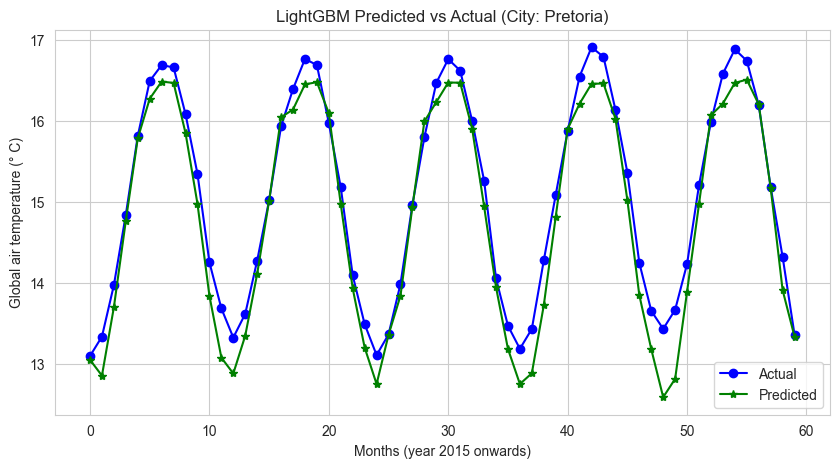

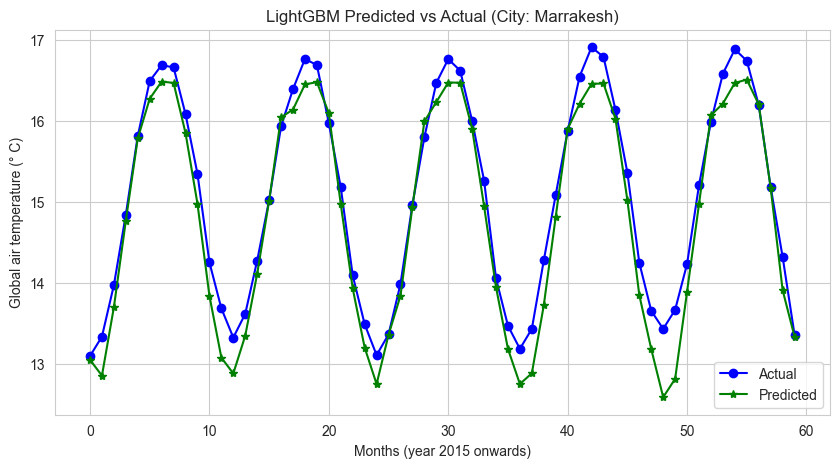

In [238]:
i = 0
for row in city_lat_long_df.iterrows():
    c = row[1].City.split("_")[-1]
    lat = row[1].Latitude
    long = row[1].Longitude
    
    dd = combined[(combined['Latitude'] == lat) & (combined['Longitude'] == long)]
    dd.reset_index(drop=True, inplace=True)
    print(dd["True"], dd["Predicted"])
    plt.figure(figsize=(10, 5))
    plt.plot(dd.index, dd["True"], label='Actual', color='blue', marker='o')
    plt.plot(dd.index, dd["Predicted"], label='Predicted', color='green', marker='*')
    plt.legend()
    plt.title(f'LightGBM Predicted vs Actual (City: {c})')
    plt.xlabel('Months (year 2015 onwards)')
    plt.ylabel('Global air temperature (° C)')
    # plt.savefig('../forecasting_results/lgbm_forecasts_sd.png')
    i+=1
    if i>=2:
        break

In [206]:
sd = combined[(combined['Latitude'] == 32.95) & (combined['Longitude'] == -117.77)]

In [207]:
sd.reset_index(drop=True, inplace=True)

In [208]:
sd

,month,Latitude,Longitude,monthly_average_co2,population,year_average_VEI,year_events_amount,temp_lag_1,temp_lag_2,temp_lag_3,...,temp_ewm_alpha_05_lag_5,temp_ewm_alpha_05_lag_6,temp_ewm_alpha_05_lag_7,temp_ewm_alpha_05_lag_8,temp_ewm_alpha_05_lag_9,temp_ewm_alpha_05_lag_10,temp_ewm_alpha_05_lag_11,temp_ewm_alpha_05_lag_12,True,Predicted
0,1,32.95,-117.77,400.18,7.404251e+09,2.000000,1.0,13.311,13.870,15.110,...,16.395188,16.110377,15.684754,15.024507,14.199015,13.559030,13.276059,13.524118,13.098,13.051033
1,2,32.95,-117.77,400.55,7.404251e+09,2.000000,1.0,13.098,13.311,13.870,...,16.247594,16.395188,16.110377,15.684754,15.024507,14.199015,13.559030,13.276059,13.338,12.856003
2,3,32.95,-117.77,401.74,7.404251e+09,2.000000,1.0,13.338,13.098,13.311,...,15.678797,16.247594,16.395188,16.110377,15.684754,15.024507,14.199015,13.559030,13.974,13.701316
3,4,32.95,-117.77,403.35,7.404251e+09,2.000000,1.0,13.974,13.338,13.098,...,14.774399,15.678797,16.247594,16.395188,16.110377,15.684754,15.024507,14.199015,14.844,14.768690
4,5,32.95,-117.77,404.15,7.404251e+09,2.000000,1.0,14.844,13.974,13.338,...,14.042699,14.774399,15.678797,16.247594,16.395188,16.110377,15.684754,15.024507,15.815,15.785941
5,6,32.95,-117.77,402.97,7.404251e+09,2.000000,1.0,15.815,14.844,13.974,...,13.570350,14.042699,14.774399,15.678797,16.247594,16.395188,16.110377,15.684754,16.494,16.274814
6,7,32.95,-117.77,401.46,7.404251e+09,2.000000,1.0,16.494,15.815,14.844,...,13.454175,13.570350,14.042699,14.774399,15.678797,16.247594,16.395188,16.110377,16.690,16.487420
7,8,32.95,-117.77,399.11,7.404251e+09,2.000000,1.0,16.690,16.494,15.815,...,13.714087,13.454175,13.570350,14.042699,14.774399,15.678797,16.247594,16.395188,16.662,16.469765
8,9,32.95,-117.77,397.82,7.404251e+09,2.000000,1.0,16.662,16.690,16.494,...,14.279044,13.714087,13.454175,13.570350,14.042699,14.774399,15.678797,16.247594,16.084,15.850917
9,10,32.95,-117.77,398.49,7.404251e+09,2.000000,1.0,16.084,16.662,16.690,...,15.047022,14.279044,13.714087,13.454175,13.570350,14.042699,14.774399,15.678797,15.347,14.977287


In [209]:
df[df["City"]=="13_SanDiego"]

,year,month,Actual Temperature,City,Country,Latitude,Longitude,Actual Temperature_Air_Global,Actual Temperature_Water_Global,monthly_average_co2,...,temp_roll_mean_3,temp_roll_mean_4,temp_roll_mean_5,temp_roll_mean_6,temp_roll_mean_7,temp_roll_mean_8,temp_roll_mean_9,temp_roll_mean_10,temp_roll_mean_11,temp_roll_mean_12
18468,1850,1,11.408,13_SanDiego,USA,32.95,-117.77,11.474,12.214,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18469,1850,2,11.573,13_SanDiego,USA,32.95,-117.77,12.227,12.993,NaN,...,11.474000,11.474000,11.474000,11.474000,11.474000,11.474000,11.474000,11.474000,11.474000,11.474000
18470,1850,3,12.300,13_SanDiego,USA,32.95,-117.77,12.706,13.444,NaN,...,11.850500,11.850500,11.850500,11.850500,11.850500,11.850500,11.850500,11.850500,11.850500,11.850500
18471,1850,4,14.075,13_SanDiego,USA,32.95,-117.77,13.396,14.119,NaN,...,12.135667,12.135667,12.135667,12.135667,12.135667,12.135667,12.135667,12.135667,12.135667,12.135667
18472,1850,5,15.049,13_SanDiego,USA,32.95,-117.77,14.324,14.887,NaN,...,12.776333,12.450750,12.450750,12.450750,12.450750,12.450750,12.450750,12.450750,12.450750,12.450750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20515,2020,8,22.544,13_SanDiego,USA,32.95,-117.77,16.744,17.191,412.75,...,16.487000,16.167250,15.781000,15.429000,15.143857,14.957875,14.879111,14.927500,15.037636,15.183833
20516,2020,9,22.966,13_SanDiego,USA,32.95,-117.77,16.197,16.606,411.50,...,16.737667,16.551250,16.282600,15.941500,15.616857,15.343875,15.156333,15.065600,15.092636,15.179833
20517,2020,10,21.521,13_SanDiego,USA,32.95,-117.77,15.183,15.582,411.48,...,16.608667,16.602500,16.480400,16.268333,15.978000,15.689375,15.438667,15.260400,15.168455,15.184667
20518,2020,11,17.210,13_SanDiego,USA,32.95,-117.77,14.323,14.716,413.10,...,16.041333,16.252250,16.318600,16.264167,16.113286,15.878625,15.633111,15.413100,15.253364,15.169667


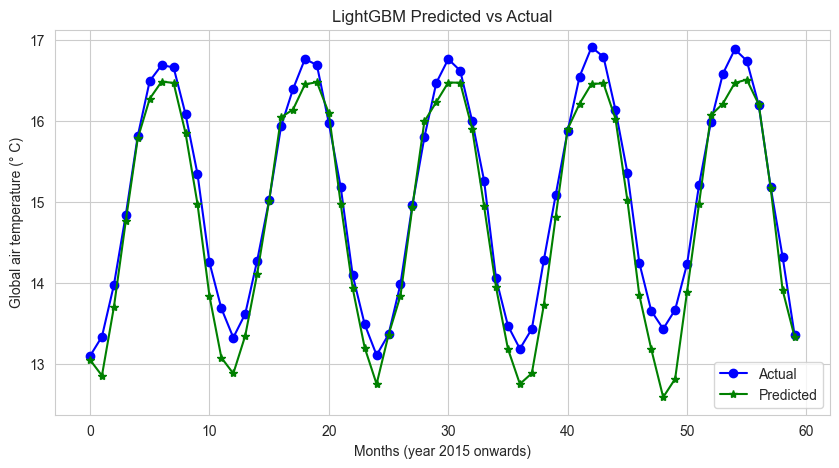

In [183]:
plt.figure(figsize=(10, 5))
plt.plot(sd.index, sd["True"], label='Actual', color='blue', marker='o')
plt.plot(sd.index, sd["Predicted"], label='Predicted', color='green', marker='*')
plt.legend()
plt.title('LightGBM Predicted vs Actual')
plt.xlabel('Months (year 2015 onwards)')
plt.ylabel('Global air temperature (° C)')
plt.savefig('../forecasting_results/lgbm_forecasts_sd.png')